In [1]:
import time
import subprocess

from PIL import Image
from PIL import ImageDraw
import numpy as np
import matplotlib.pyplot as plt

from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file
from pycoral.utils.edgetpu import make_interpreter


In [2]:
def draw_objects(draw, objs, labels):
    """Draws the bounding box and label for each object."""
    for obj in objs:
        bbox = obj.bbox
        draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)], outline="red")
        draw.text(
            (bbox.xmin + 10, bbox.ymin + 10),
            "%s\n%.2f" % (labels.get(obj.id, obj.id), obj.score),
            fill="red",
        )

In [3]:
det_base_model_path = (
    "object_detection_model/model/efficientdet_lite_0/efficientdet-lite.tflite"
)
det_tpu_model_path = (
    "experiments/co_compile_obj_cls/model/ours/efficientdet-lite_edgetpu.tflite"
)
cls_base_model_paths = [
    "experiments/co_compile_obj_cls/model/ours/segmented/inception_v2_224_quant_segment/3/inception_v2_224_quant_segment_0_of_3.tflite",
    "experiments/co_compile_obj_cls/model/ours/segmented/inception_v2_224_quant_segment/3/inception_v2_224_quant_segment_1_of_3.tflite",
    "experiments/co_compile_obj_cls/model/ours/segmented/inception_v2_224_quant_segment/3/inception_v2_224_quant_segment_2_of_3.tflite",
]
cls_tpu_model_paths = [
    "experiments/co_compile_obj_cls/model/ours/segmented/inception_v2_224_quant_segment/3/result/inception_v2_224_quant_segment_0_of_3_edgetpu.tflite",
    "experiments/co_compile_obj_cls/model/ours/segmented/inception_v2_224_quant_segment/3/result/inception_v2_224_quant_segment_1_of_3_edgetpu.tflite",
    "experiments/co_compile_obj_cls/model/ours/segmented/inception_v2_224_quant_segment/3/result/inception_v2_224_quant_segment_2_of_3_edgetpu.tflite",
]


dummy_model_path = "experiments/co_compile_obj_cls/model/i200_f20_l6.tflite"

det_out_dir = "experiments/co_compile_obj_cls/model/ours"
cls_out_dir = (
    "experiments/co_compile_obj_cls/model/ours/segmented/inception_v2_224_quant_segment/3/result"
)

labels = read_label_file("data/object_detection/labels.txt")


In [ ]:
cmd = f"edgetpu_compiler -o {det_out_dir} "
cmd += f"{det_base_model_path} "
for _ in range(47):
    cmd += f"{dummy_model_path} "

result = subprocess.check_output(cmd, shell=True)

In [4]:
cmd = f"edgetpu_compiler -o {cls_out_dir} "
for _ in range(78):
    cmd += f"{dummy_model_path} "
for p in cls_base_model_paths:
    cmd += f"{p} "

result = subprocess.check_output(cmd, shell=True)

In [ ]:
print(result.decode())

In [4]:
det_intp = make_interpreter(det_tpu_model_path)
det_intp.allocate_tensors()

image = Image.open("experiments/co_compile_obj_cls/test_image.JPEG")

_, scale = common.set_resized_input(
    det_intp, image.size, lambda size: image.resize(size, Image.ANTIALIAS)
)

In [5]:
for _ in range(5):
    start = time.perf_counter()
    det_intp.invoke()
    inference_time = time.perf_counter() - start
    objs = detect.get_objects(det_intp, 0.5, scale)
    print("%.2f ms" % (inference_time * 1000))

35.64 ms
21.47 ms
17.62 ms
17.16 ms
17.18 ms


In [6]:
for obj in objs:
    print(labels.get(obj.id, obj.id))
    print("  id:    ", obj.id)
    print("  score: ", obj.score)
    print("  bbox:  ", obj.bbox)

person 1
  id:     0
  score:  0.98828125
  bbox:   BBox(xmin=420, ymin=53, xmax=517, ymax=239)


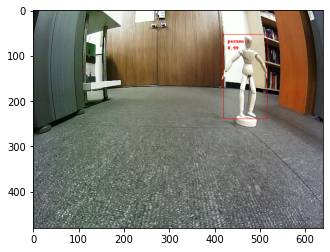

In [7]:
image = Image.open("experiments/co_compile_obj_cls/test_image.JPEG")
image = image.convert("RGB")
draw_objects(ImageDraw.Draw(image), objs, labels)
plt.imshow(image)

In [8]:
cls_intps = [make_interpreter(p) for p in cls_tpu_model_paths]
for cls_intp in cls_intps:
    cls_intp.allocate_tensors()


In [9]:
for _ in range(2):
    for cls_intp in cls_intps:
        start = time.perf_counter()
        cls_intp.invoke()
        inference_time = time.perf_counter() - start
        print("%.2f ms" % (inference_time * 1000))
    print()

9.10 ms
12.67 ms
11.57 ms

8.69 ms
12.23 ms
8.78 ms



In [10]:
for _ in range(5):
    start = time.perf_counter()
    det_intp.invoke()
    inference_time = time.perf_counter() - start
    objs = detect.get_objects(det_intp, 0.5, scale)
    print("%.2f ms" % (inference_time * 1000))

22.05 ms
13.02 ms
11.37 ms
11.58 ms
13.70 ms


In [11]:
for obj in objs:
    print(labels.get(obj.id, obj.id))
    print("  id:    ", obj.id)
    print("  score: ", obj.score)
    print("  bbox:  ", obj.bbox)

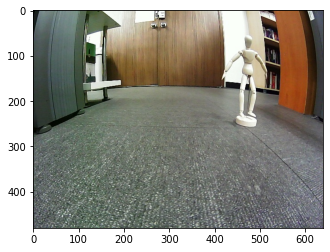

In [12]:
image = Image.open("experiments/co_compile_obj_cls/test_image.JPEG")
image = image.convert("RGB")
draw_objects(ImageDraw.Draw(image), objs, labels)
plt.imshow(image)